In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize, Minuit

In [31]:
# Fixed the bins, colors, JSF_arr arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_mid = bins[:-1]+bins_w/2
bins_dense = np.linspace(bins_min, bins_max, 1000)

bins_pdf_min, bins_pdf_max = 100, 250
bins_pdf = np.arange(bins_pdf_min, bins_pdf_max+1, bins_w)
bins_pdf_mid = bins_pdf[:-1] + bins_w/2
bins_pdf_dense = np.linspace(bins_pdf_min, bins_pdf_max, 1000)

JSF_arr = [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03]
JSF_dense = np.linspace(0.97, 1.03, 1000)

loglikeli_cut_min = -78
loglikeli_cut_max = -55
marginal_prob_cut = 0.23

sudo_event = 1000

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
two_gau_fit_labels = ['Mean of  first Gaussian', 'Variance of first Gaussian', 'Mean of  second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']

In [32]:
def get_reco_top_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and JSF_arr from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_JSF_arr'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_JSF_arr'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_JSF_arr'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_JSF_arr']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_JSF_arr']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_JSF_arr']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_JSF_arr'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    bins_min < reco_m_top < bins_max
    """
    cuts = np.logical_and(dic['reconstructed_top_JSF_arr'] > bins_min, dic['reconstructed_top_JSF_arr'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, reco_cuts, np.logical_and(h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut_min, h5py_file['klfitter/score/loglikelihood'][:]<loglikeli_cut_max)
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    

In [33]:
# The reco_top_mss from ttbar_testing_JSF_arr_variation
# 0 for unmatched, 1 for incorrect, 2 for correct

reco_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}
reco_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}

h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_173_gev_with_spanet_pdnn_KLFitter.h5', "r")
for JSF in JSF_arr:
    reco_klf_dic[JSF], state_klf_dic[JSF], cut_klf_dic[JSF], likeli_klf_dic[JSF]  = get_reco_top_mass(h5py_file, 'klfitter', JSF)
    reco_spanet_dic[JSF], state_spanet_dic[JSF], cut_spanet_dic[JSF], likeli_spanet_dic[JSF] = get_reco_top_mass(h5py_file, 'spanet', JSF)


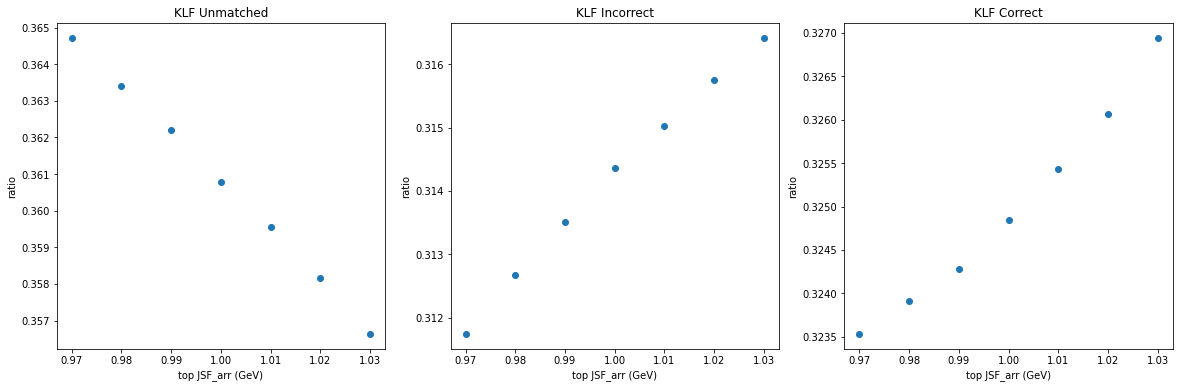

In [34]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(JSF_arr):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])])
        ratio_klf_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(JSF_arr, ratio_klf_dic[state_i])
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top JSF_arr (GeV)')
    plt.ylabel('ratio')
plt.show()
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}

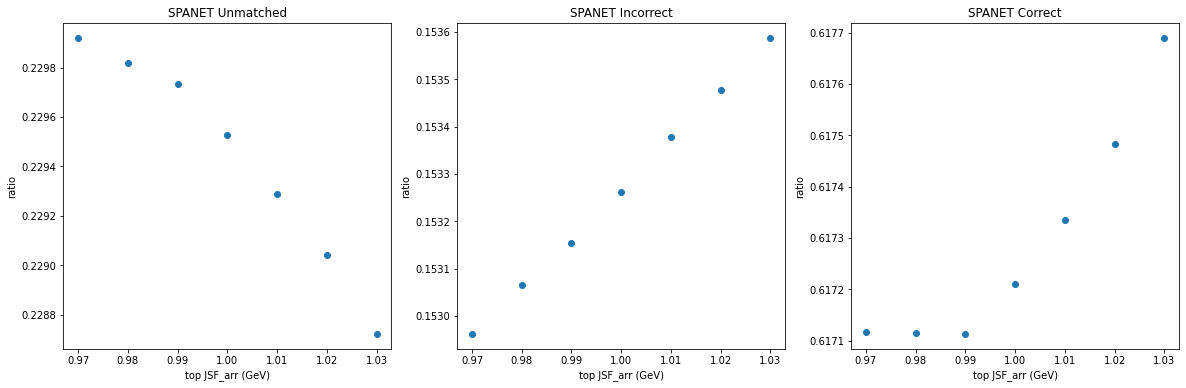

In [35]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(JSF_arr):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])])
        ratio_spanet_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(JSF_arr, ratio_spanet_dic[state_i])
    plt.title('SPANET ' + state_labels[state_i])
    plt.xlabel('top JSF_arr (GeV)')
    plt.ylabel('ratio')
plt.show()
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}

In [36]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, x[0]-bins_w/2, x[-1]+bins_w/2, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
# Nomalized
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Normalized between bins_min and bins_max
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, x[0]-bins_w/2, x[-1]+bins_w/2, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

def voigt(x, shift, sigma, gamma):
    return scipy.special.voigt_profile(x - shift, sigma, gamma)

def voigt_norm(x, shift, sigma, gamma):
    return voigt(x, shift, sigma, gamma)/integrate.quad(voigt, bins_min, bins_max, args=(shift, sigma, gamma))[0]

# Linear
def linear(x, a, b):
    return a*x+b

def fcn(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(bins_mid_fcn, lan_loc, lan_scale, gau_loc, gau_scale, f)))

def chi2_pdf(observed, pdf, bins): #observed is the observation, pdf is the normalized height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

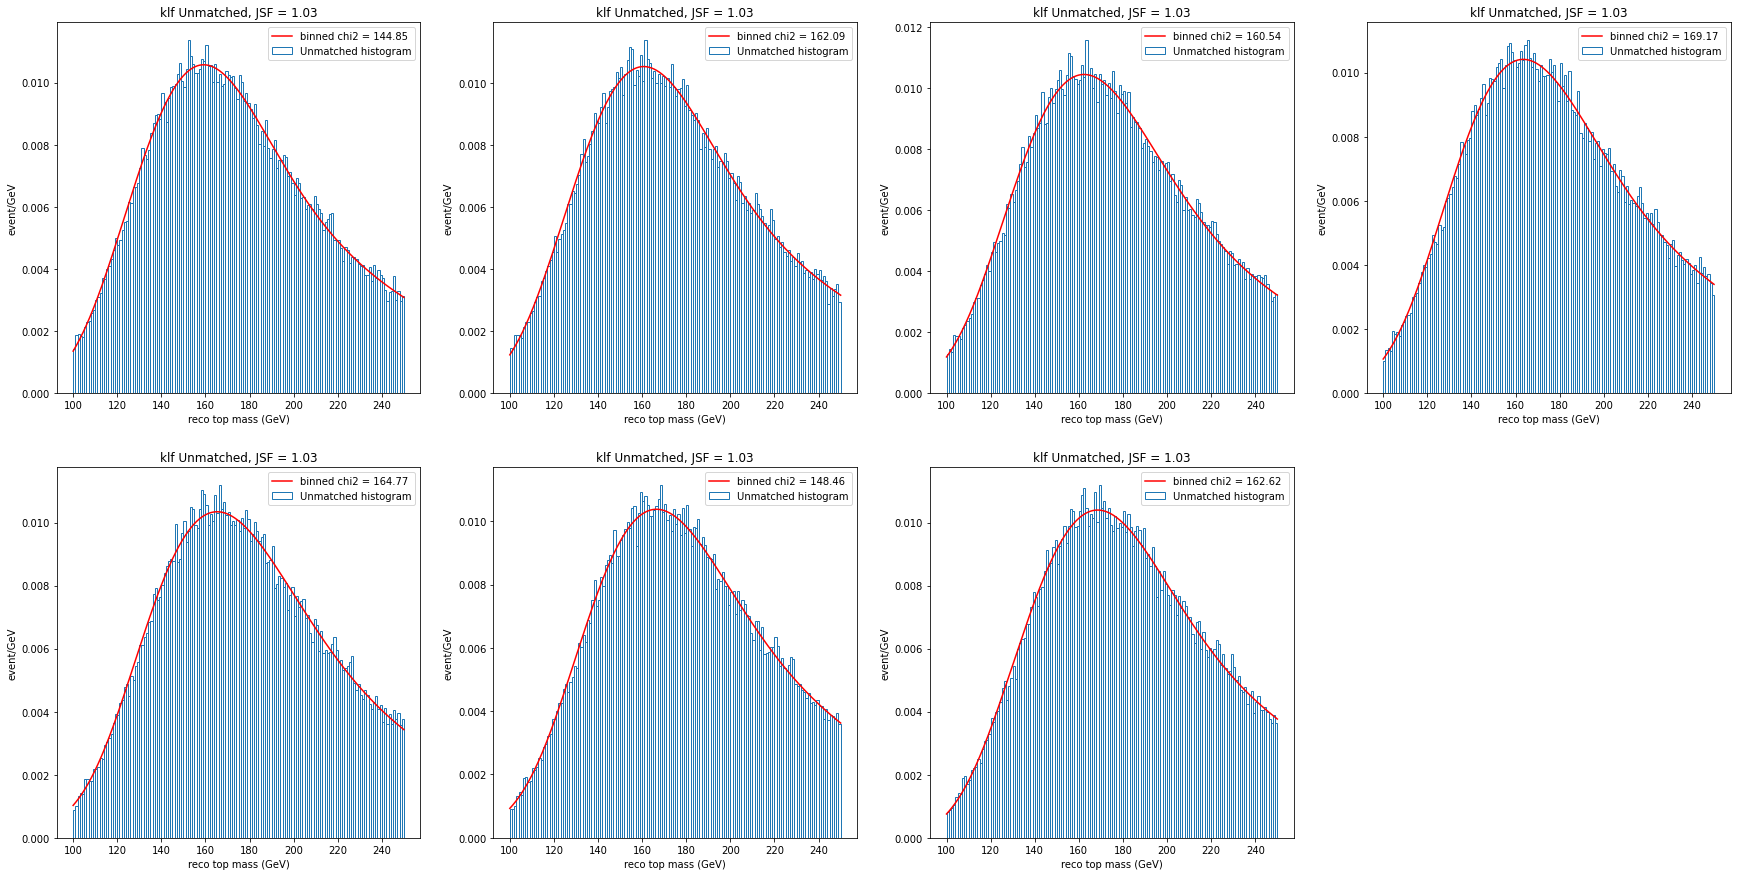

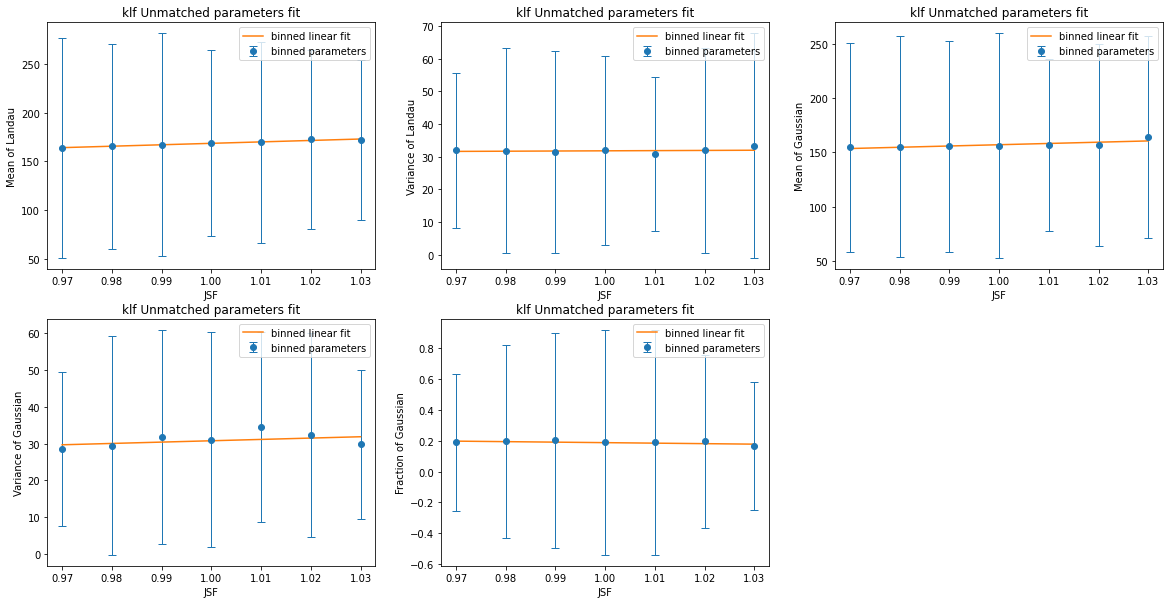

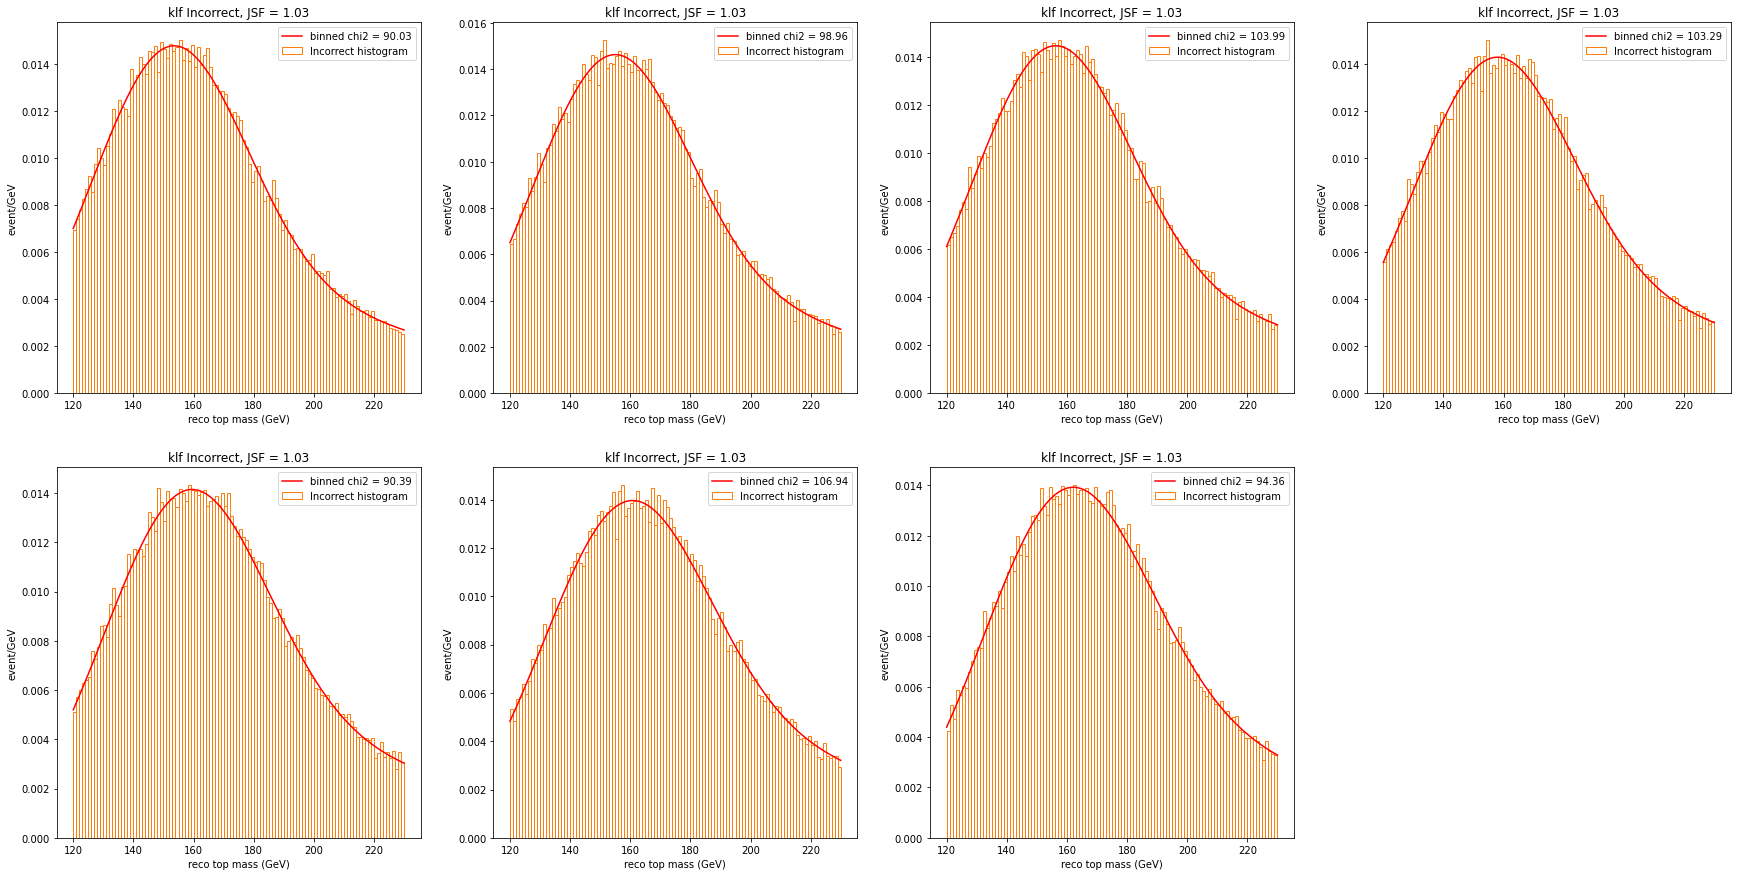

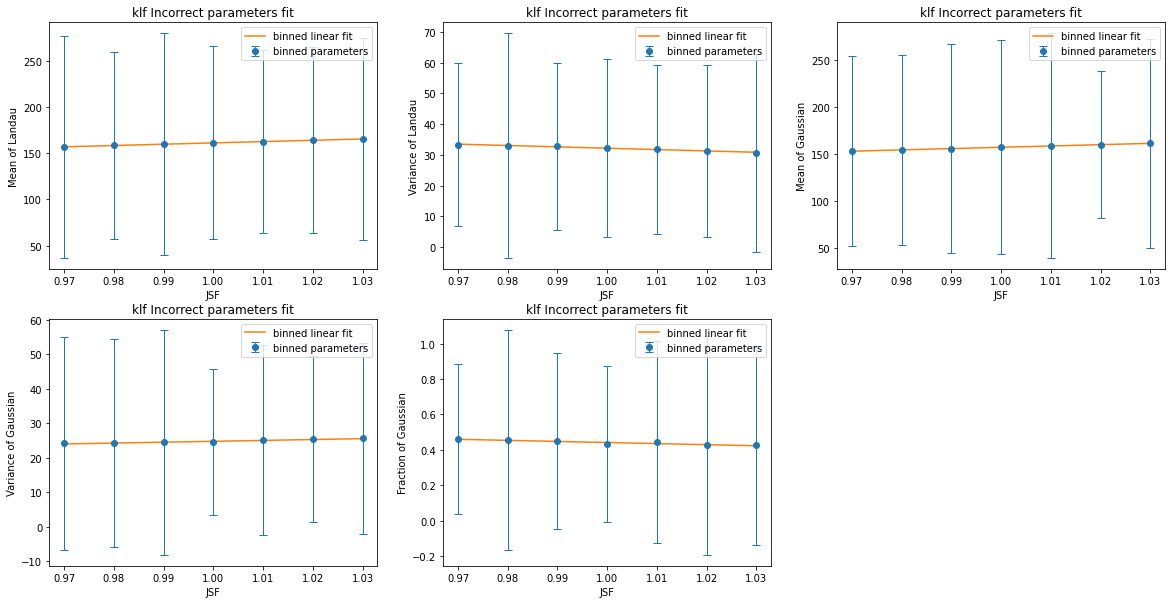

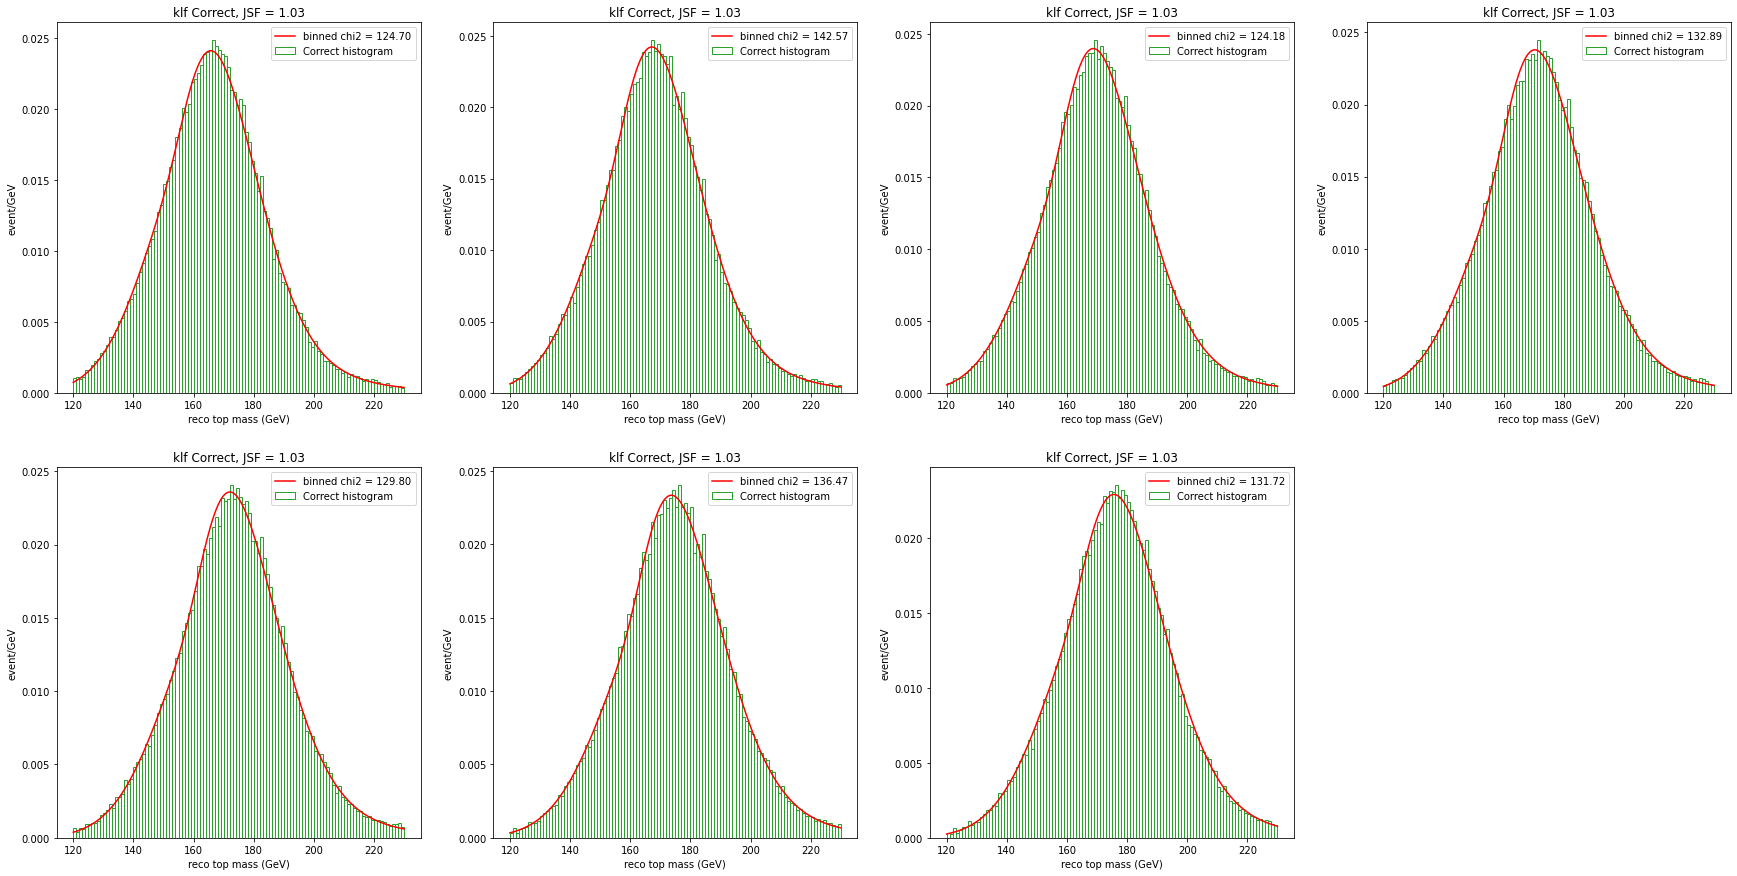

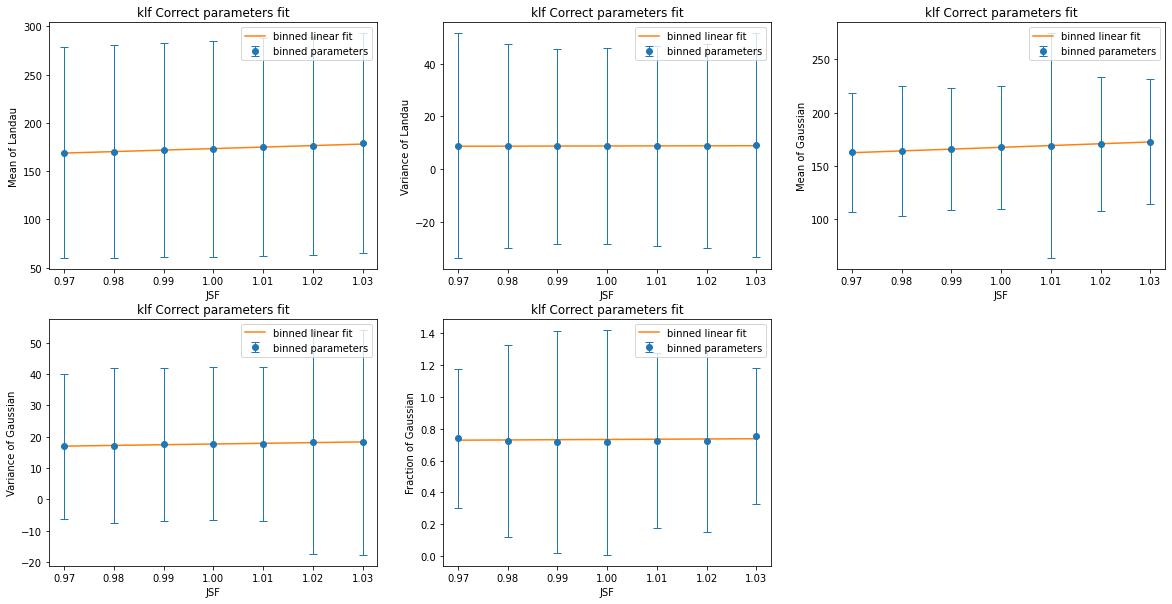

In [44]:
# Fit every class of klfitter
fita_klf_dic, fitb_klf_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_klf_arr = []
    perr_klf_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        if state_i == 0:
            fit_target = reco_klf_dic[m][np.logical_and.reduce((reco_klf_dic[m]>bins_pdf_min, reco_klf_dic[m]<bins_pdf_max, likeli_klf_dic[m], state_klf_dic[m]==state_i))]
            hist, _ = np.histogram(fit_target, bins=bins_pdf, density=True)
            sigma = np.sqrt(np.histogram(fit_target, bins=bins_pdf)[0])/len(fit_target)
            bins_mid_fcn = bins_pdf_mid
        else:
            fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)
            sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
            bins_mid_fcn = bins_mid

        minuit = Minuit(fcn, 170, 30, 170, 30, 0.5)
        minuit.limits = [(100, 250), (5, 50), (100, 250), (10, 50), (0.1, 0.9)]
        minuit.migrad(iterate=1000)
        minuit.minos()
        popt = list(minuit.values)
        pcov = list(minuit.errors)
        if state_i == 0:
            y_dense = langau_norm(bins_pdf_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins_pdf_mid, *popt), bins_pdf)
            plt.plot(bins_pdf_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
            plt.bar(bins_pdf_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        else:
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt), bins)
            plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
            plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        popt_klf_arr.append(popt)
        perr_klf_arr.append(pcov)
        plt.title('klf {}, JSF = {}'.format(state_labels[state_i], JSF))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.show()

    popt_klf_arr = np.transpose(np.array(popt_klf_arr))
    fit_popt_dic[state_i] = popt_klf_arr
    perr_klf_arr = np.transpose(np.array(perr_klf_arr))
    fita_klf_arr, fitb_klf_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_klf_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, JSF_arr, arr, sigma=perr_klf_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(JSF_arr, arr, yerr = perr_klf_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        fita_klf_arr.append(popt[0])
        fitb_klf_arr.append(popt[1])
        y = linear(JSF_dense, popt[0], popt[1])
        plt.plot(JSF_dense, y, label='binned linear fit')
        plt.title('klf {} parameters fit'.format(state_labels[state_i]))
        plt.xlabel('JSF')
        plt.ylabel(langau_fit_labels[i])
        plt.legend(loc='upper right')
    plt.show()
    fita_klf_dic[state_i] = fita_klf_arr
    fitb_klf_dic[state_i] = fitb_klf_arr

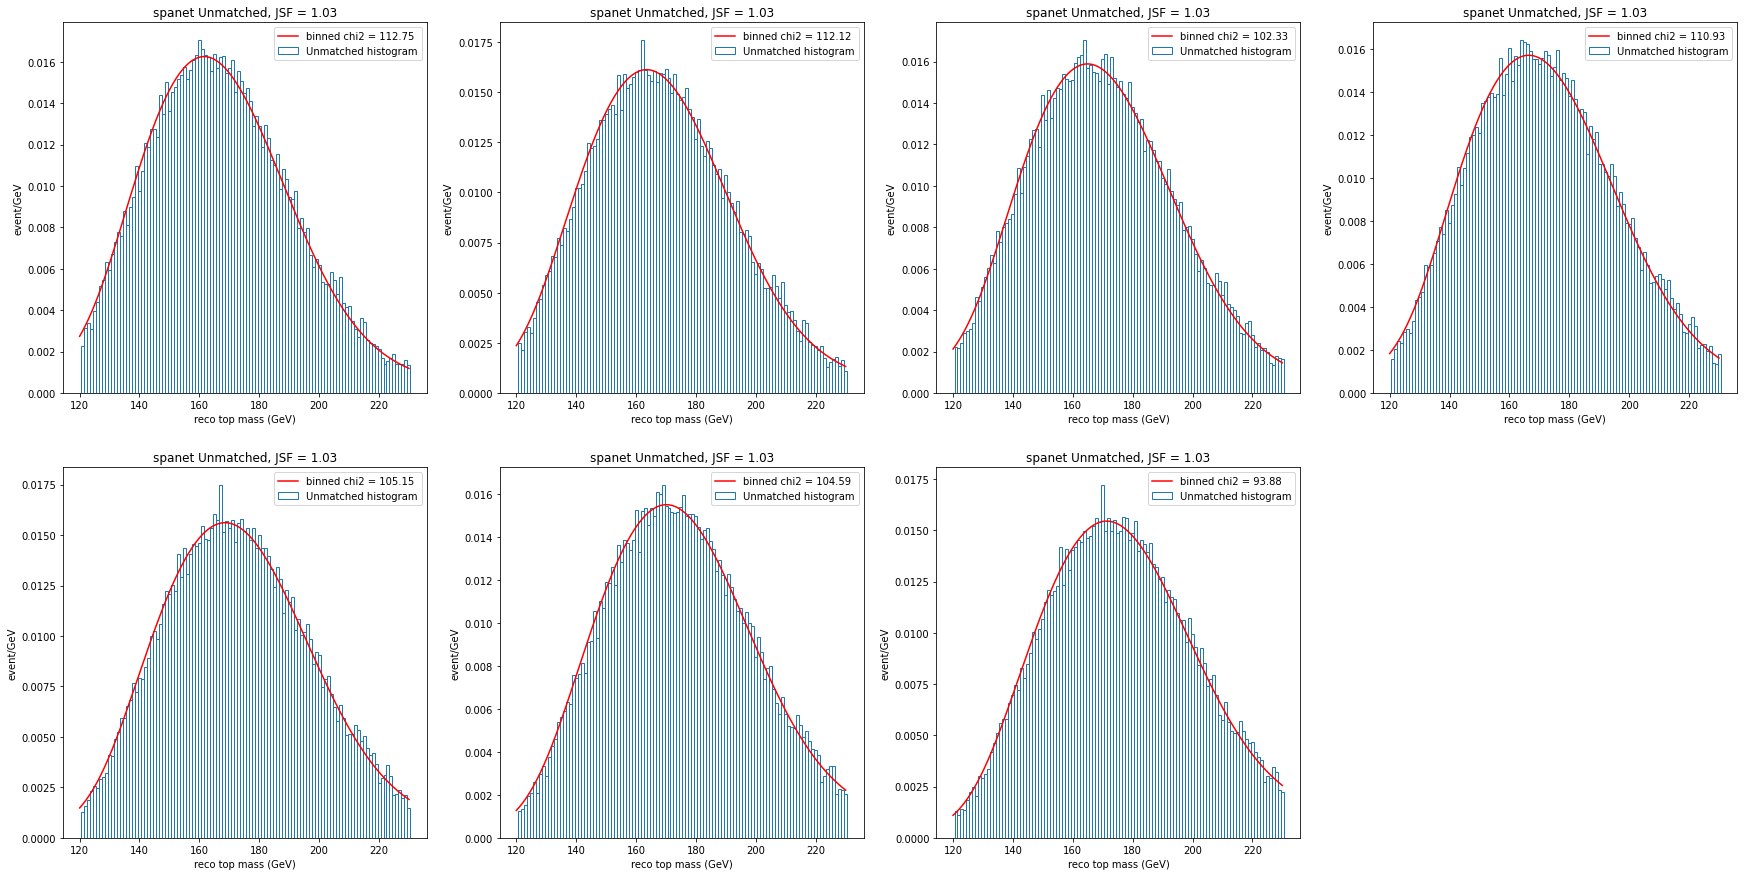

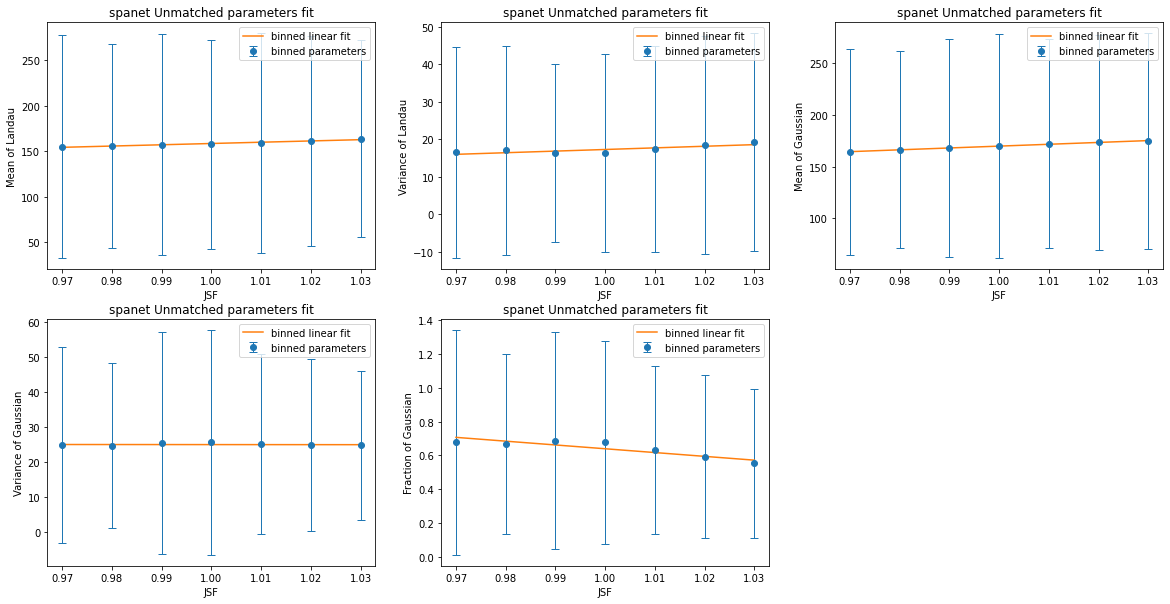

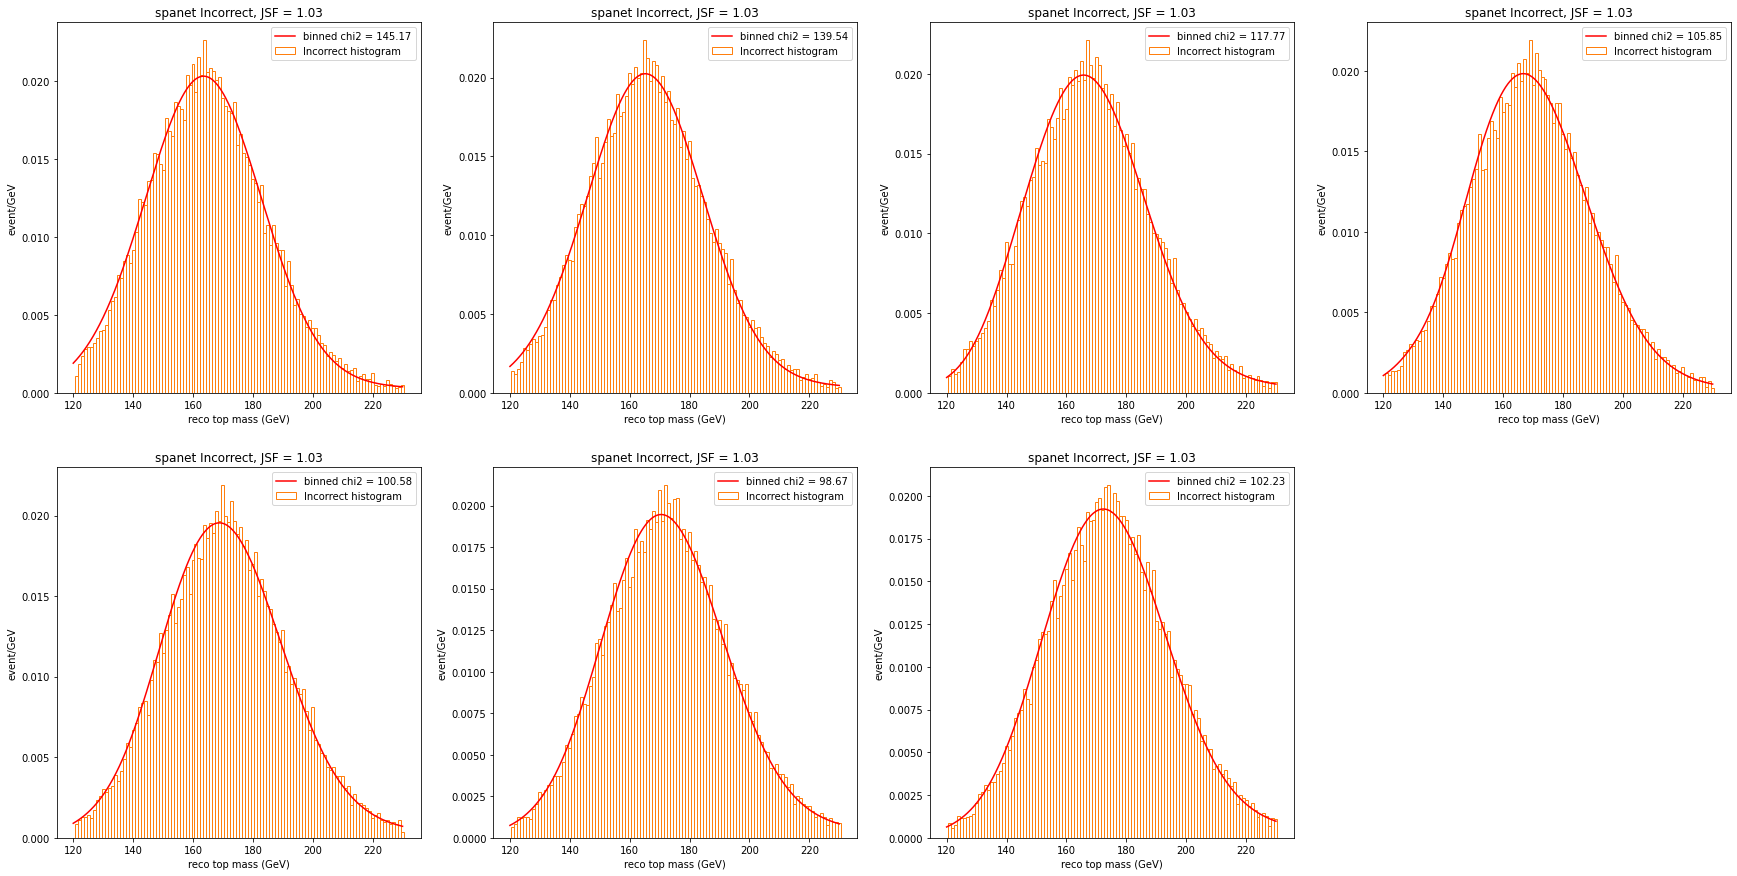

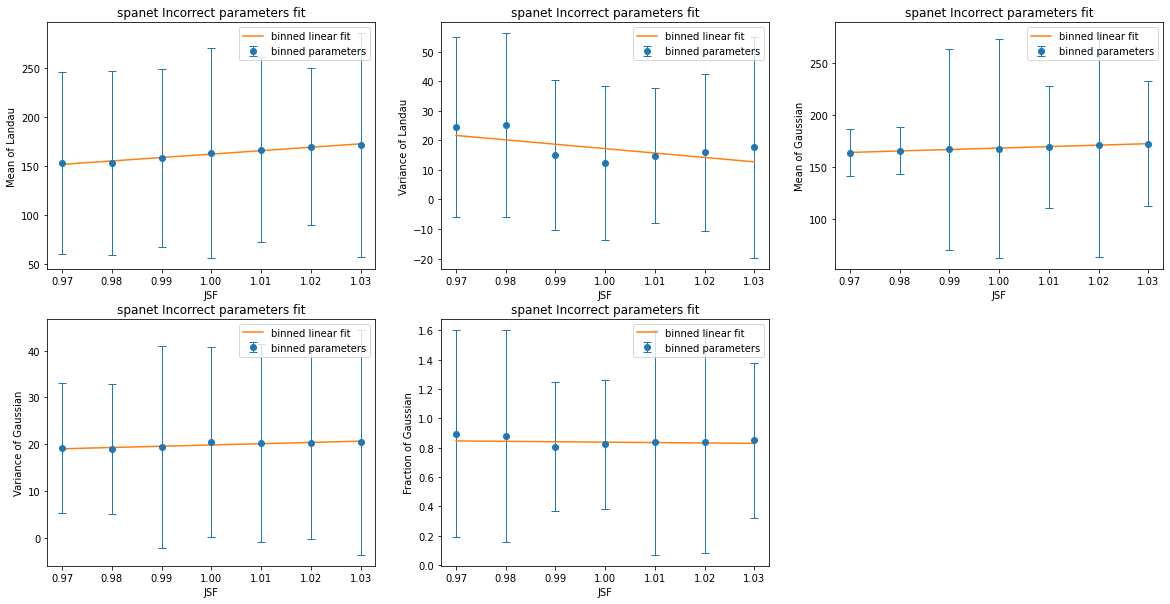

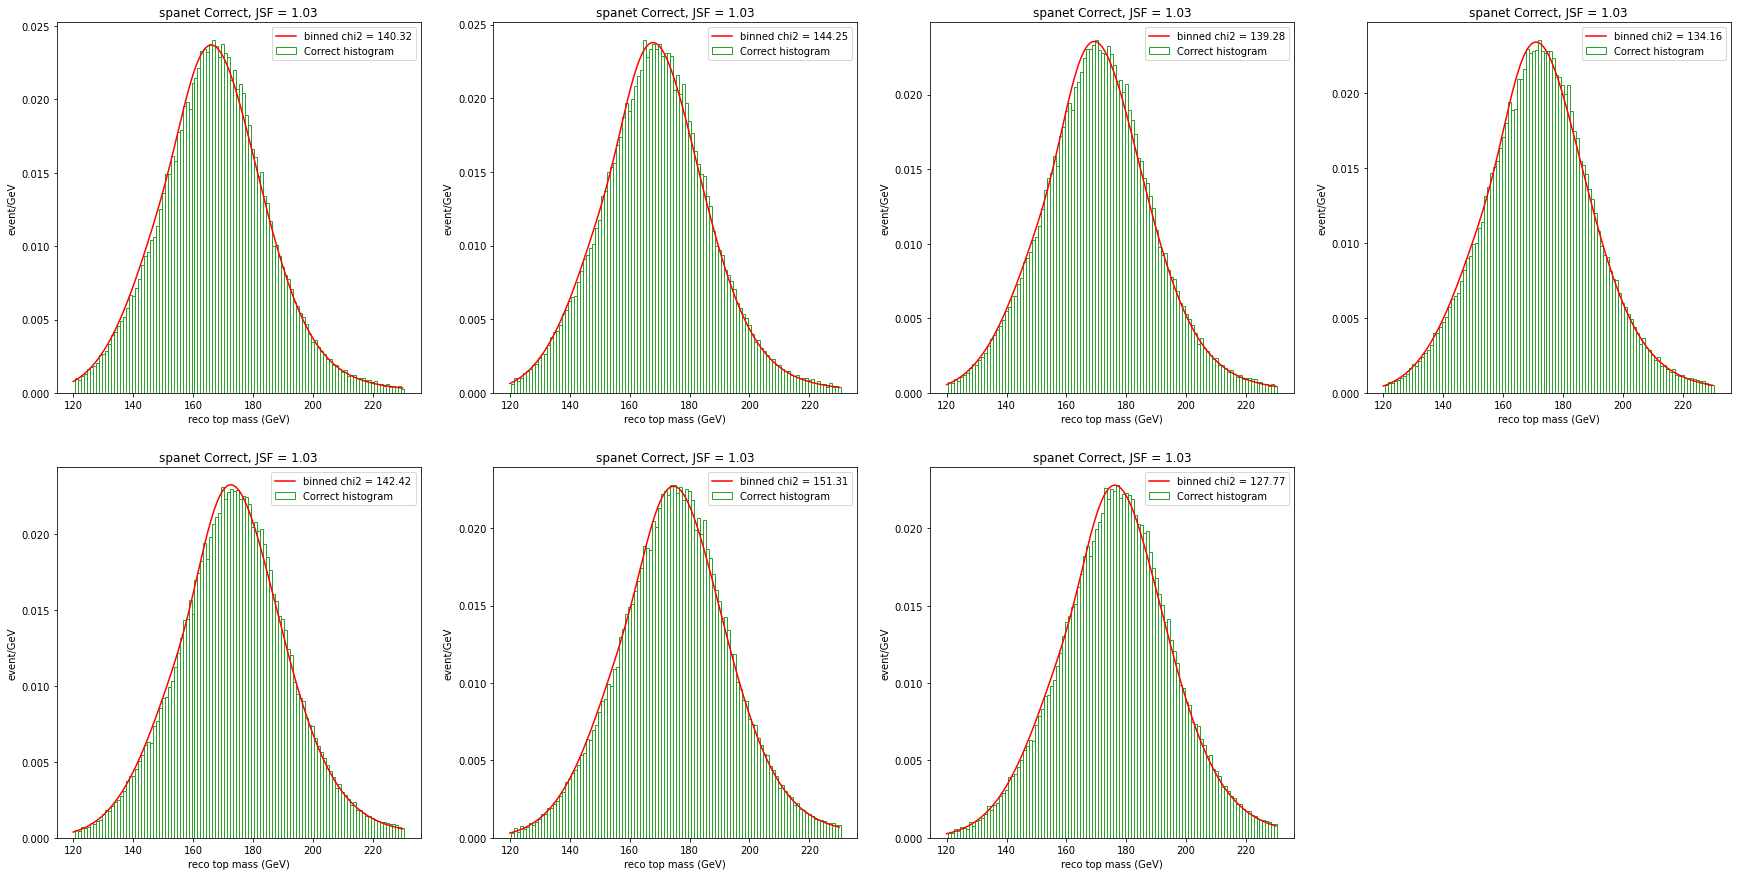

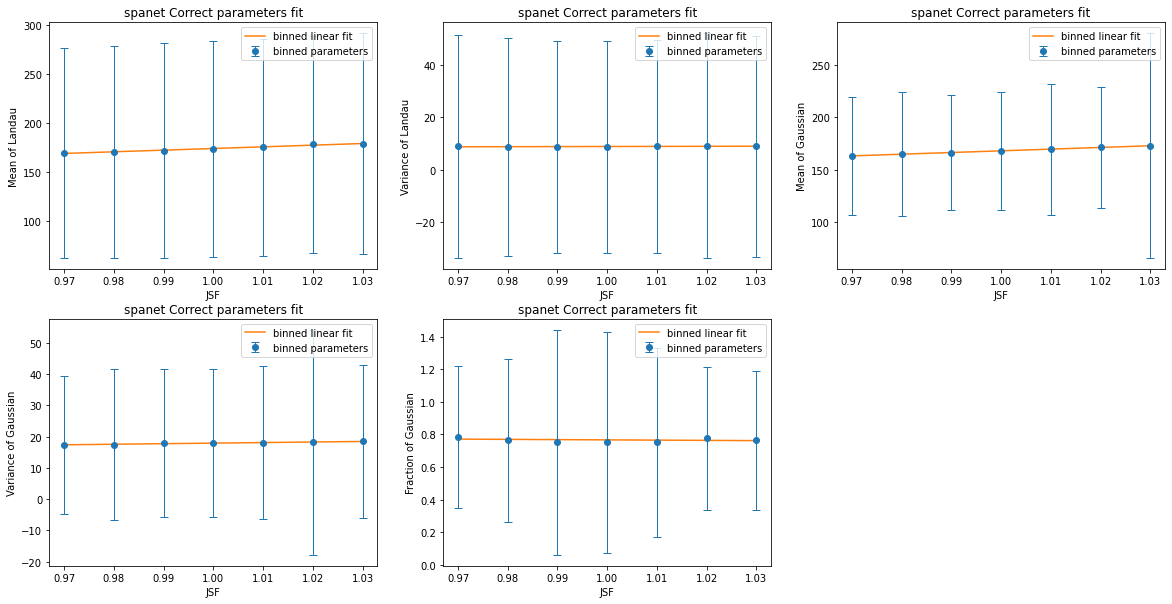

In [45]:
# Fit every class of spanet
fita_spanet_dic, fitb_spanet_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_spanet_arr = []
    perr_spanet_arr = []
    
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m]==state_i, likeli_spanet_dic[m]))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        minuit = Minuit(fcn, 170, 30, 170, 30, 0.5)
        minuit.limits = [(100, 250), (5, 50), (100, 250), (10, 50), (0.1, 0.9)]
        minuit.migrad(iterate=1000)
        minuit.minos()
        popt = list(minuit.values)
        errors = list(minuit.errors)
        popt_spanet_arr.append(popt)
        perr_spanet_arr.append(errors)
        y_dense = langau_norm(bins_dense, *popt)
        chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt), bins)
        plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.title('spanet {}, JSF = {}'.format(state_labels[state_i], JSF))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc = 'upper right')
    plt.show()

    popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    fit_popt_dic[state_i] = popt_spanet_arr
    perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    fita_spanet_arr, fitb_spanet_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_spanet_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, JSF_arr, arr, sigma=perr_spanet_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(JSF_arr, arr, yerr = perr_spanet_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        fita_spanet_arr.append(popt[0])
        fitb_spanet_arr.append(popt[1])
        y = linear(JSF_dense, popt[0], popt[1])
        plt.plot(JSF_dense, y, label='binned linear fit')
        plt.title('spanet {} parameters fit'.format(state_labels[state_i]))
        plt.xlabel('JSF')
        plt.ylabel(langau_fit_labels[i])
        plt.legend(loc='upper right')
    plt.show()
    fita_spanet_dic[state_i] = fita_spanet_arr
    fitb_spanet_dic[state_i] = fitb_spanet_arr

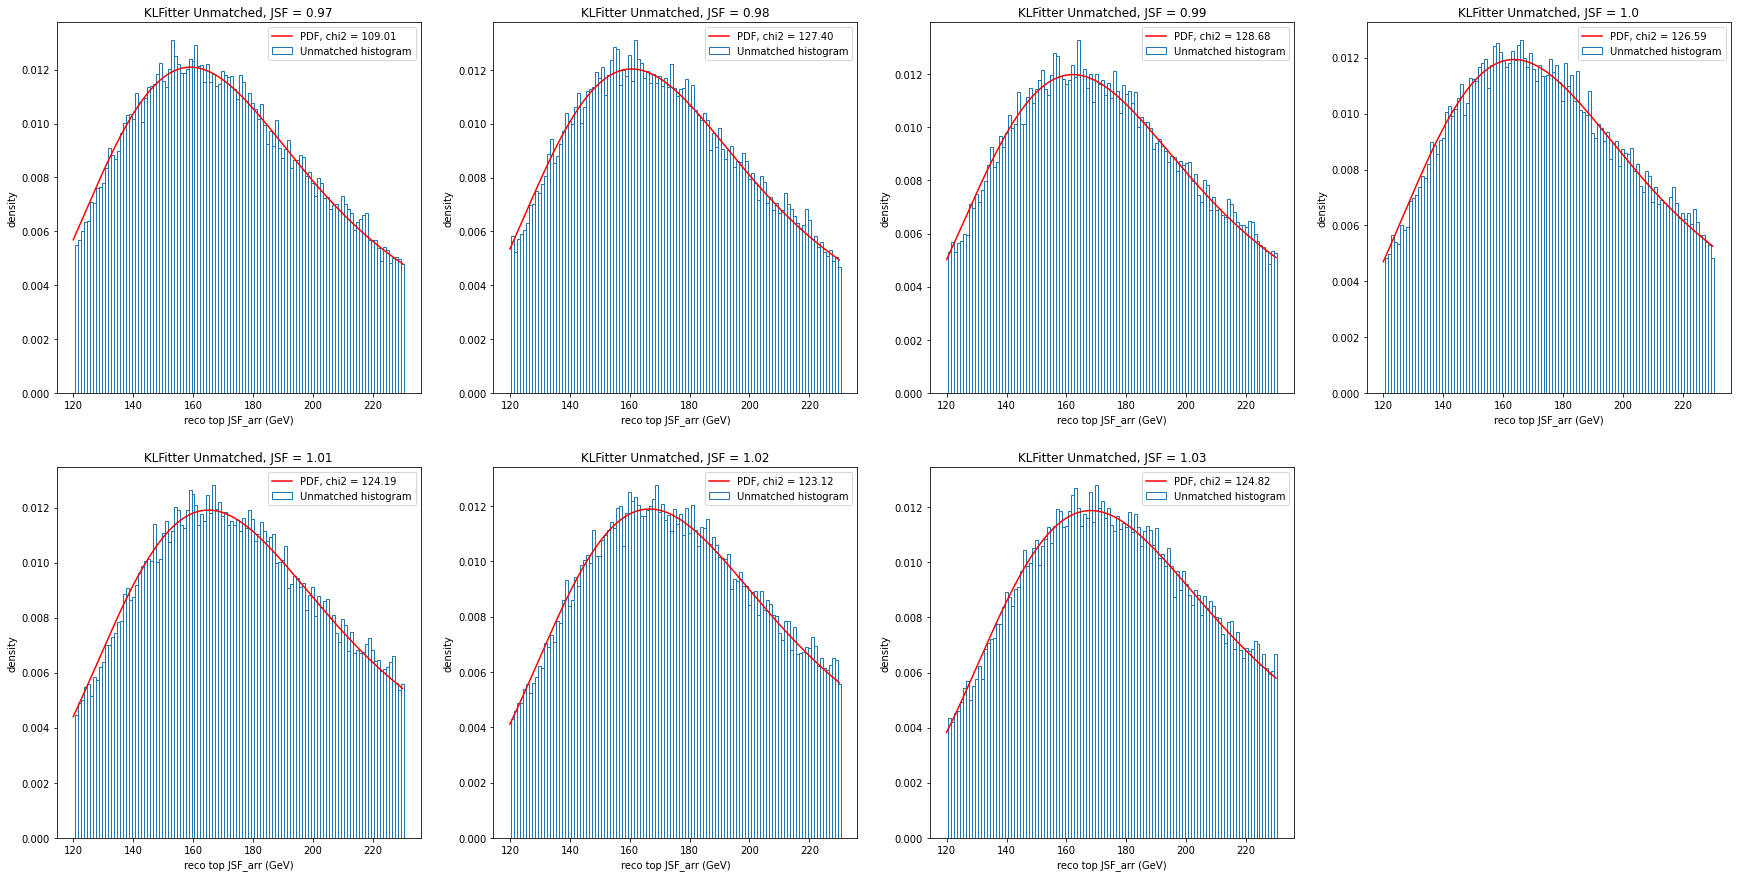

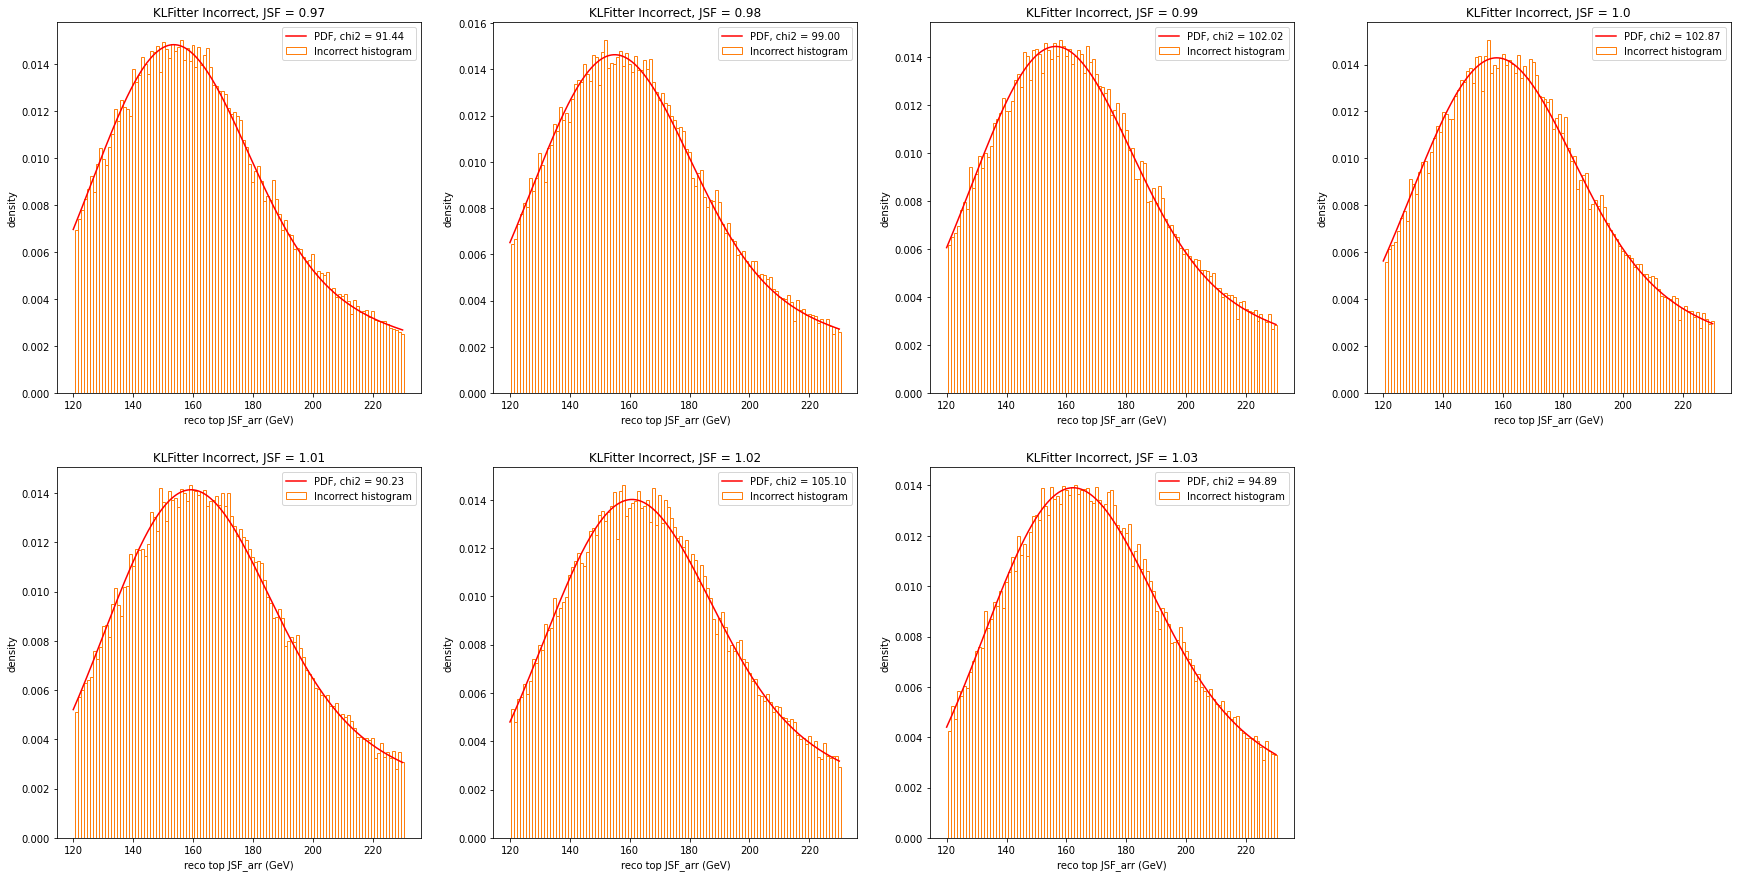

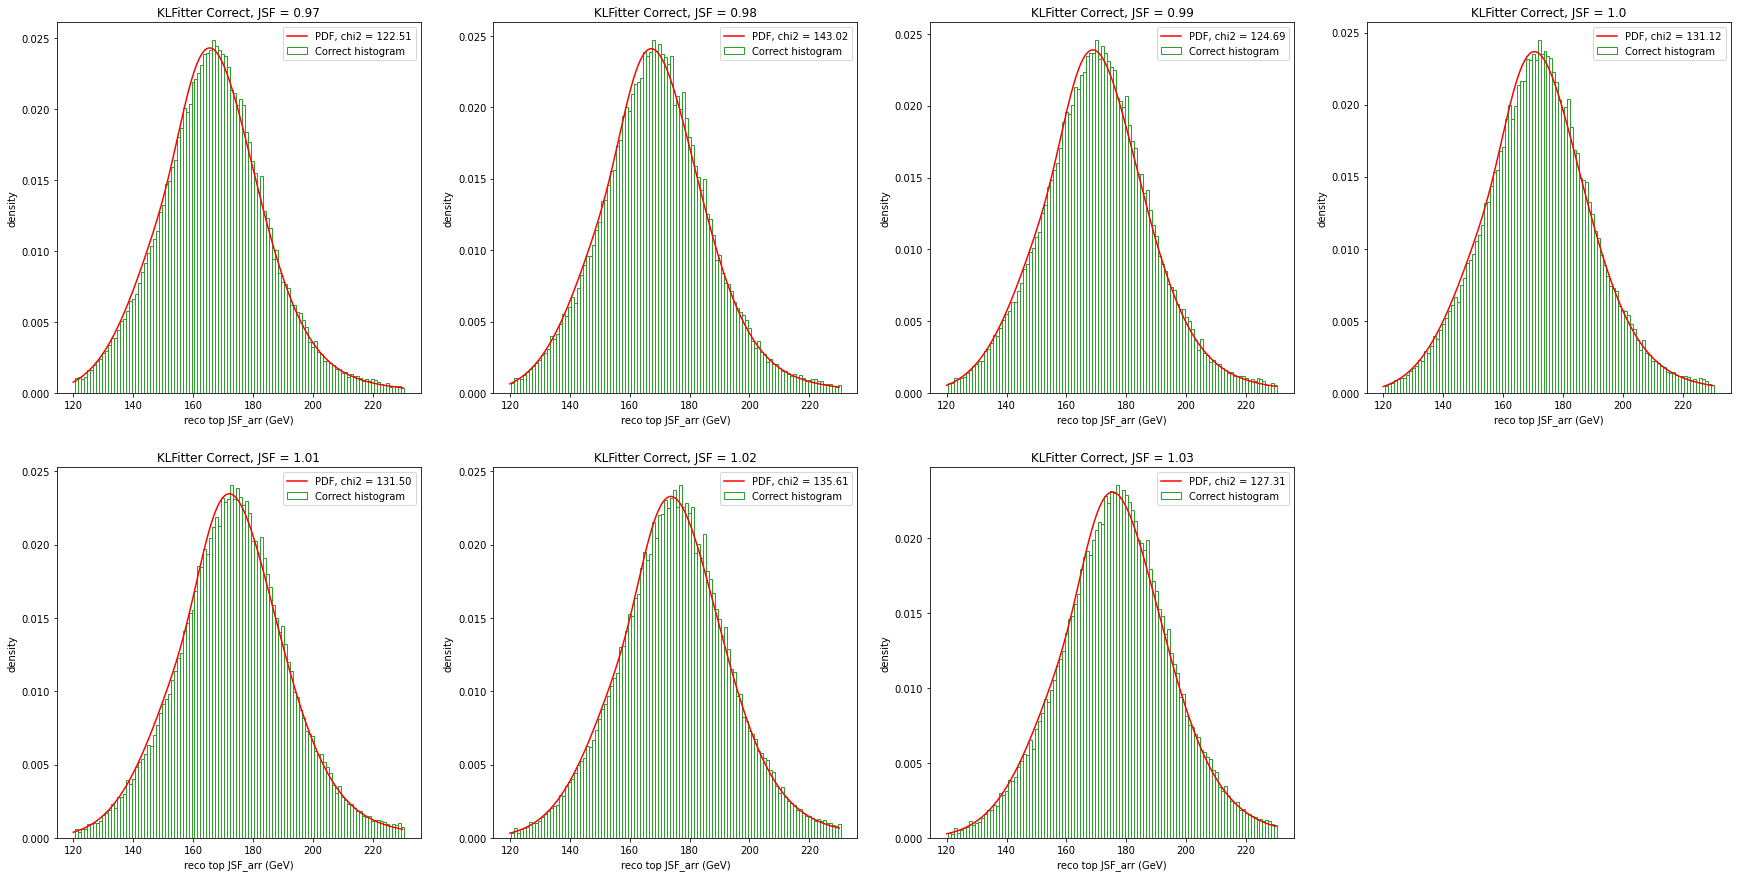

In [46]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, likeli_klf_dic[m]))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_klf_dic[state_i])*m+fitb_klf_dic[state_i]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt), bins)
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {}, JSF = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top JSF_arr (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

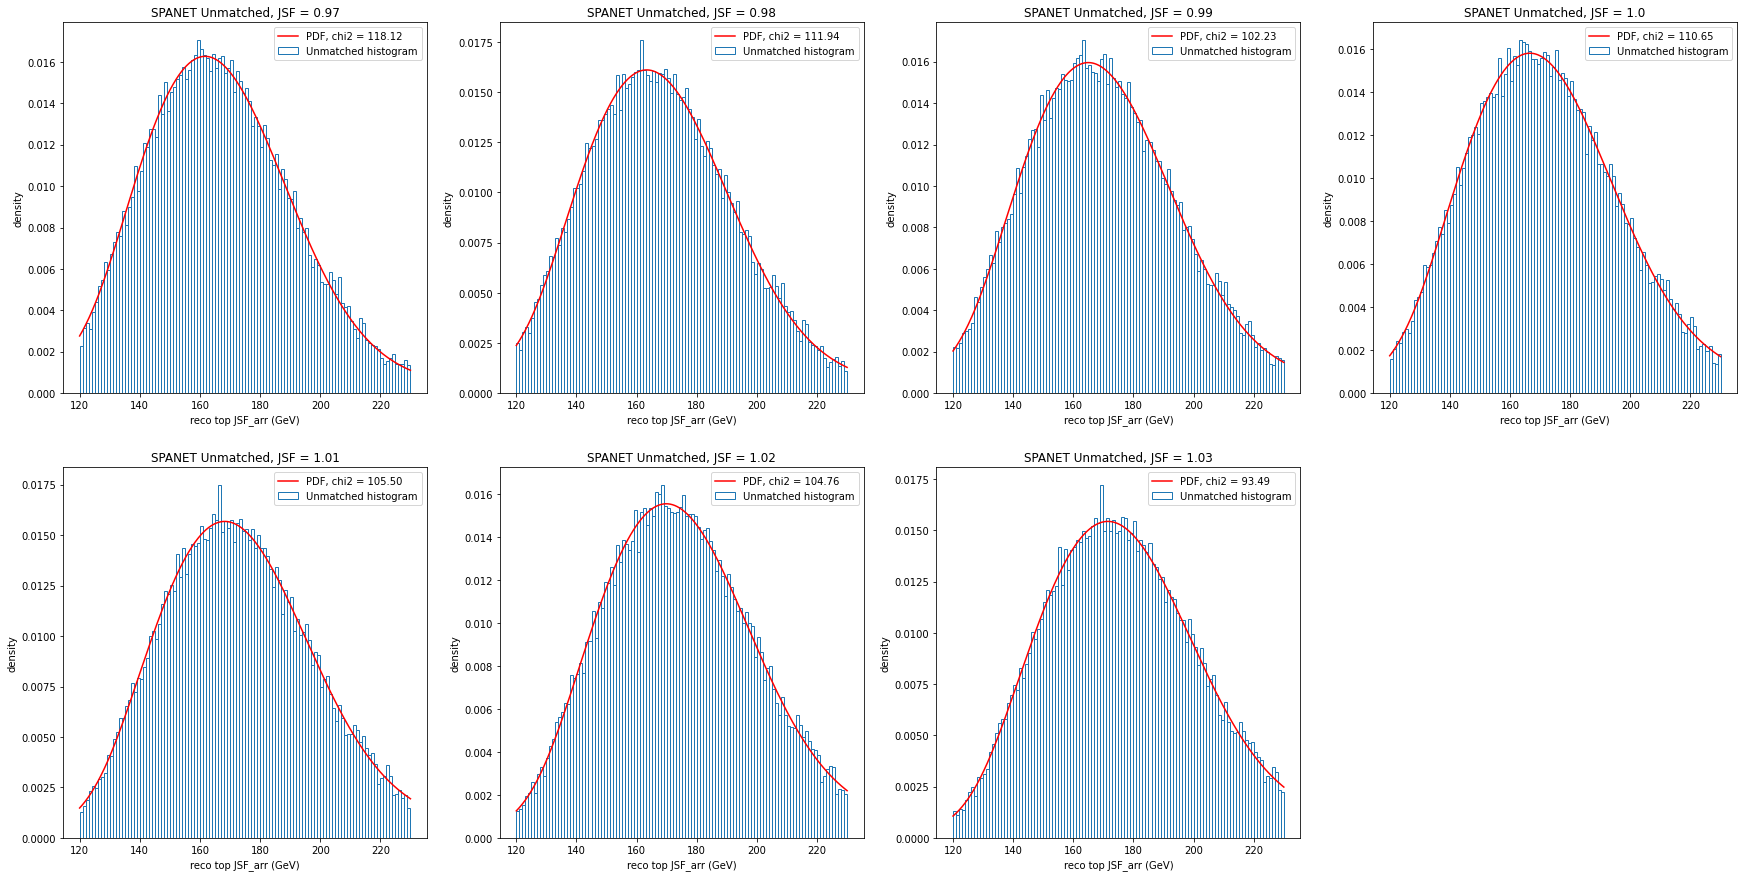

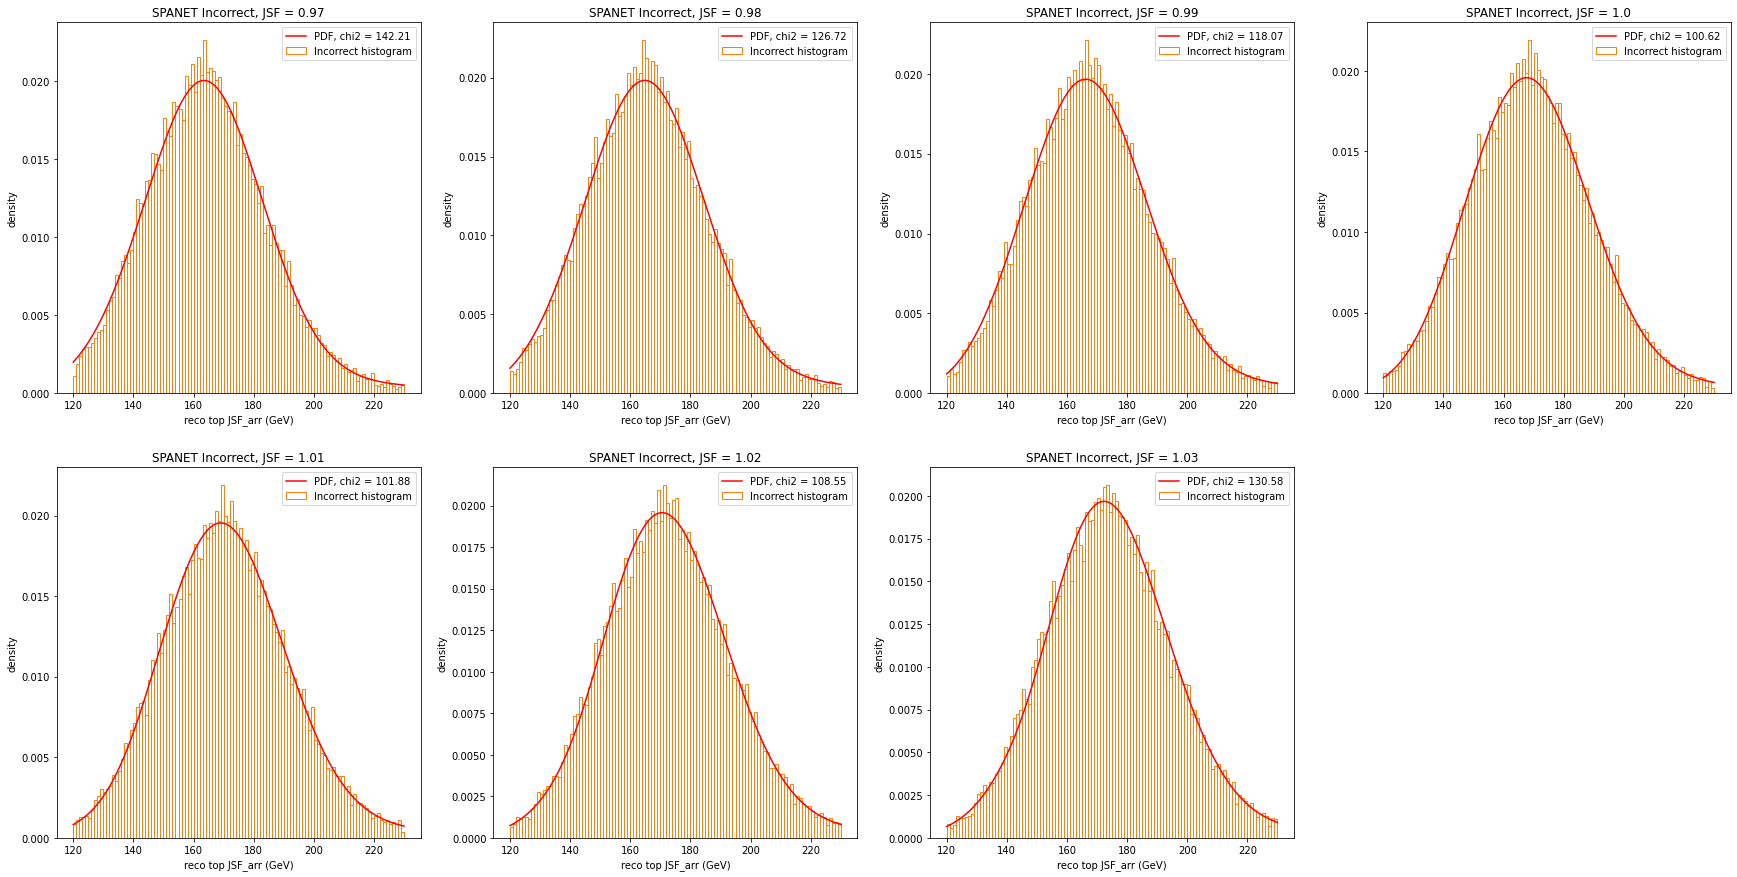

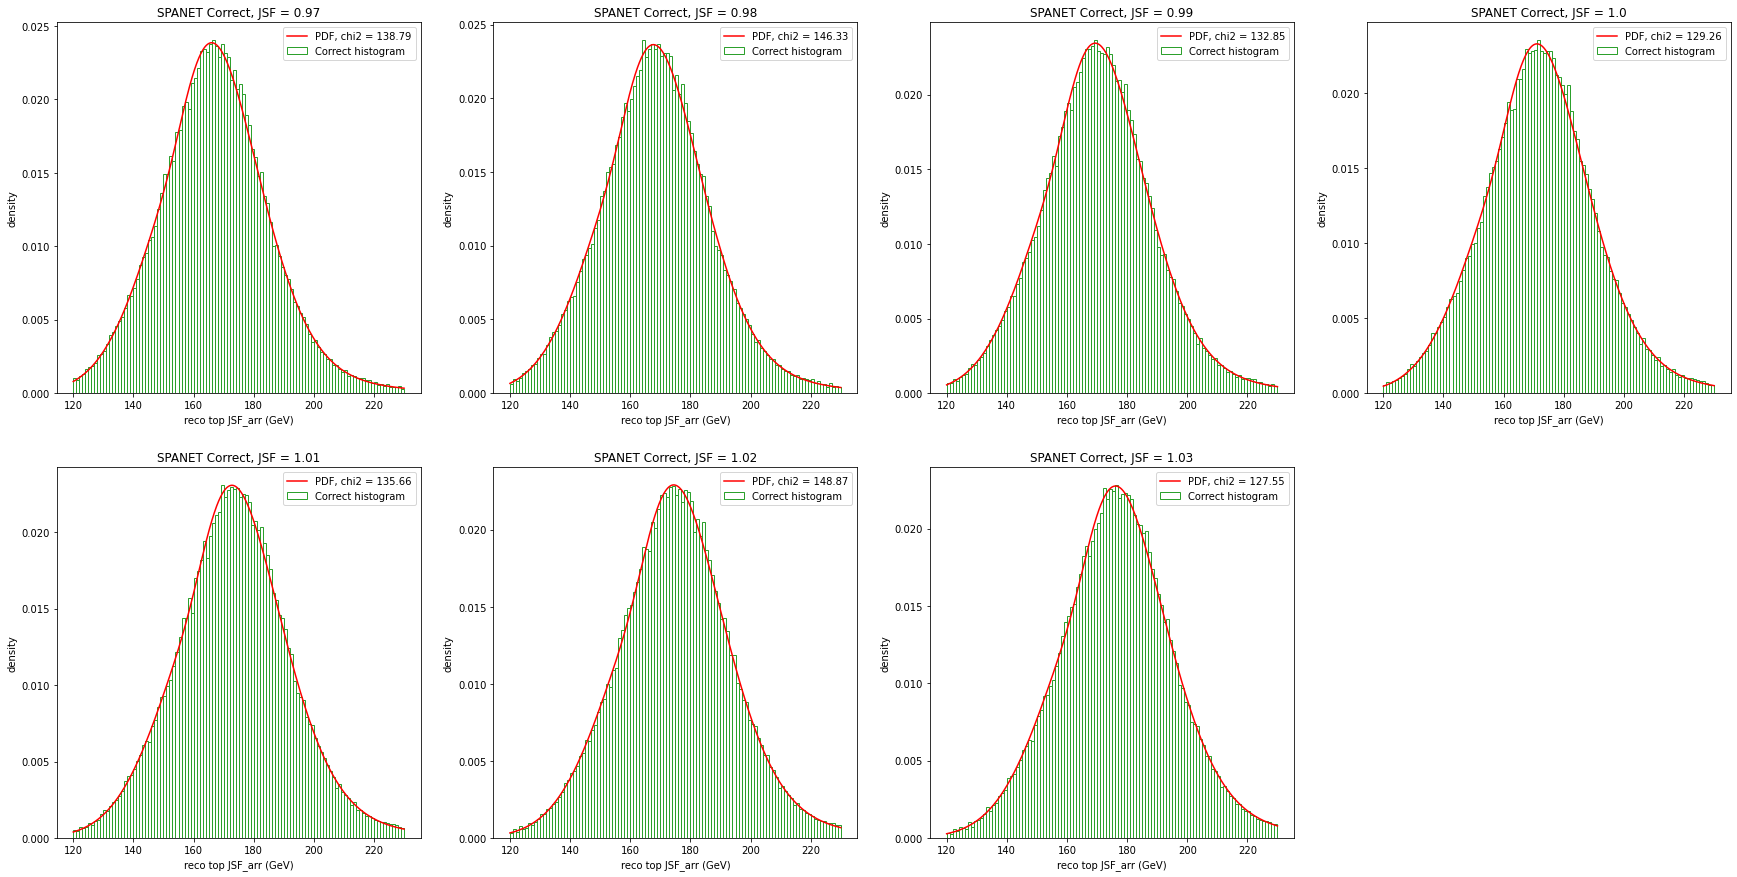

In [47]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m]==state_i, likeli_spanet_dic[m]))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt), bins)
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPANET {}, JSF = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top JSF_arr (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

In [48]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_klf_dic[state_i])*m + fitb_klf_dic[state_i]
        hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_spanet_dic[state_i])*m + fitb_spanet_dic[state_i]
        hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

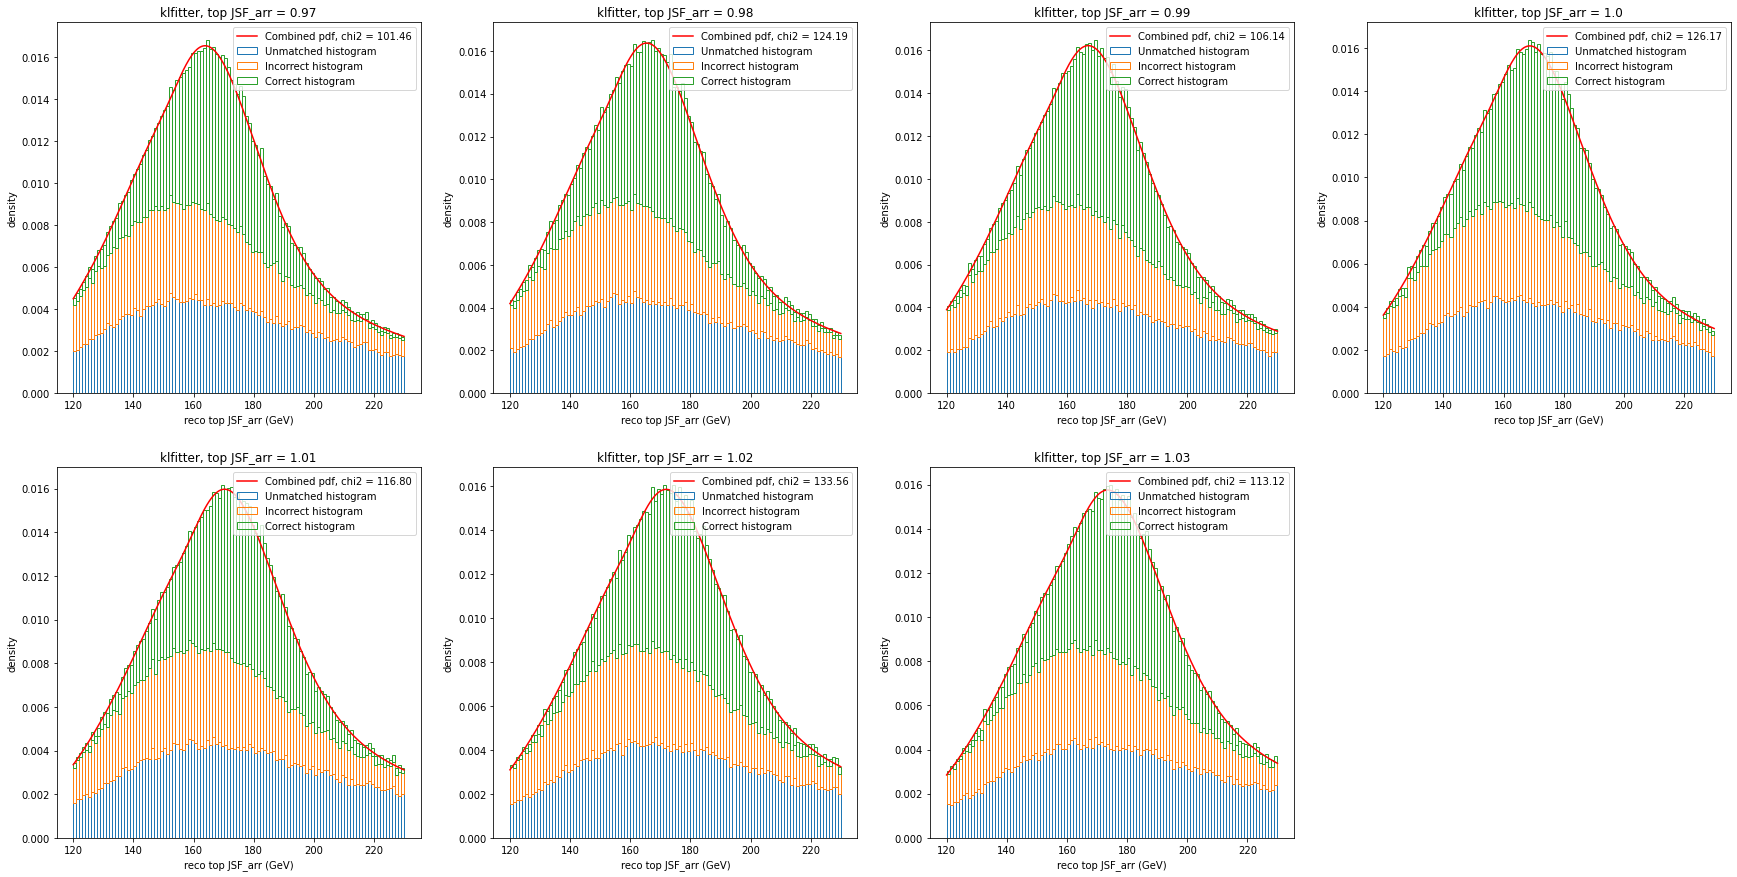

In [53]:
plt.figure(figsize=(30,15))
for i, m in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m]))]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m), bins)

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, cut_klf_dic[m], likeli_klf_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('klfitter, top JSF_arr = {}'.format(m))
    plt.xlabel('reco top JSF_arr (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

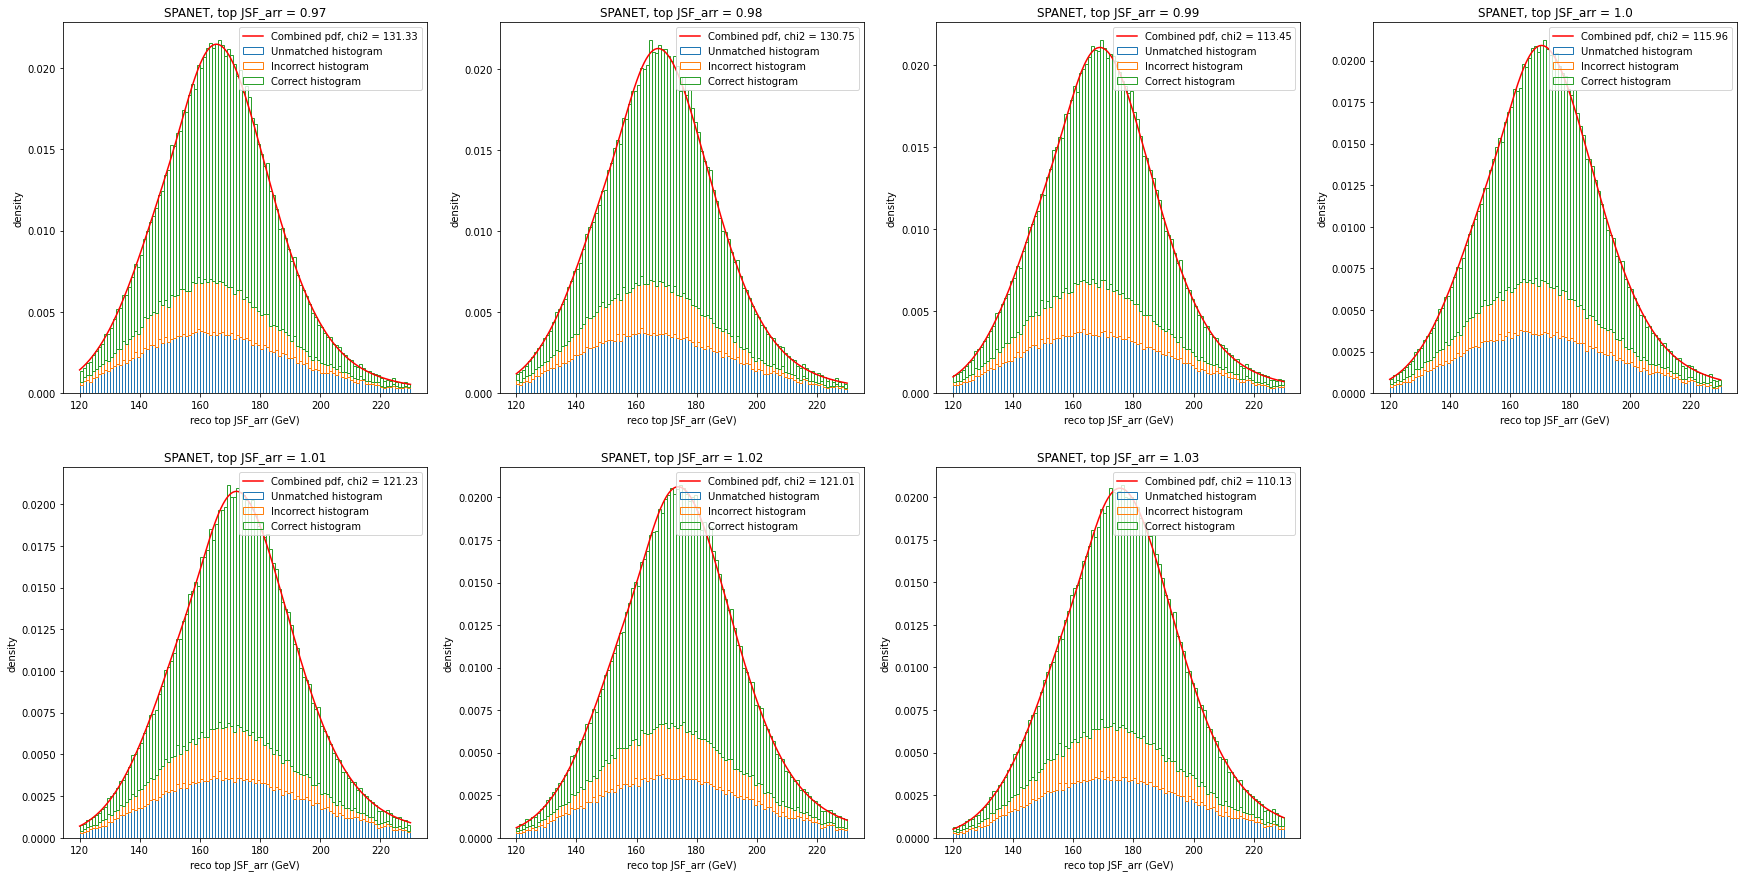

In [54]:
plt.figure(figsize=(30,15))
for i, m in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m]))]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins_mid, m), bins)

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, cut_spanet_dic[m], likeli_spanet_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPANET, top JSF_arr = {}'.format(m))
    plt.xlabel('reco top JSF_arr (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [55]:
def chi2_klf_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_klf_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_spanet_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_spanet_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

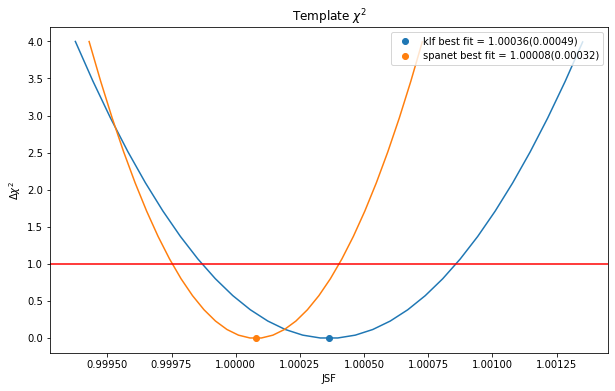

In [57]:
plt.figure(figsize=(10, 6))
m = 1
sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m]))]
n1 = np.histogram(sudo_klf, bins=bins)[0]

minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.limits=[(0.95, 1.05)]
minuit.migrad()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))

sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m]))]
n1 = np.histogram(sudo_spanet, bins=bins)[0]

minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.limits=[(0.95, 1.05)]
minuit.migrad()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='spanet best fit = {:.5f}({:.5f})'.format(minuit.values['m'], minuit.errors['m']))

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('JSF')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [60]:
#Sudo experiment for KLFitter top mass
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}

for m in JSF_arr:
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in range(sudo_event):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_klf_arr_func, m=m)
        minuit.limits=[(0.95, 1.05)]
        minuit.migrad()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_klf_top_mean_dic[m] = mean
    sudo_klf_top_std_dic[m] = std

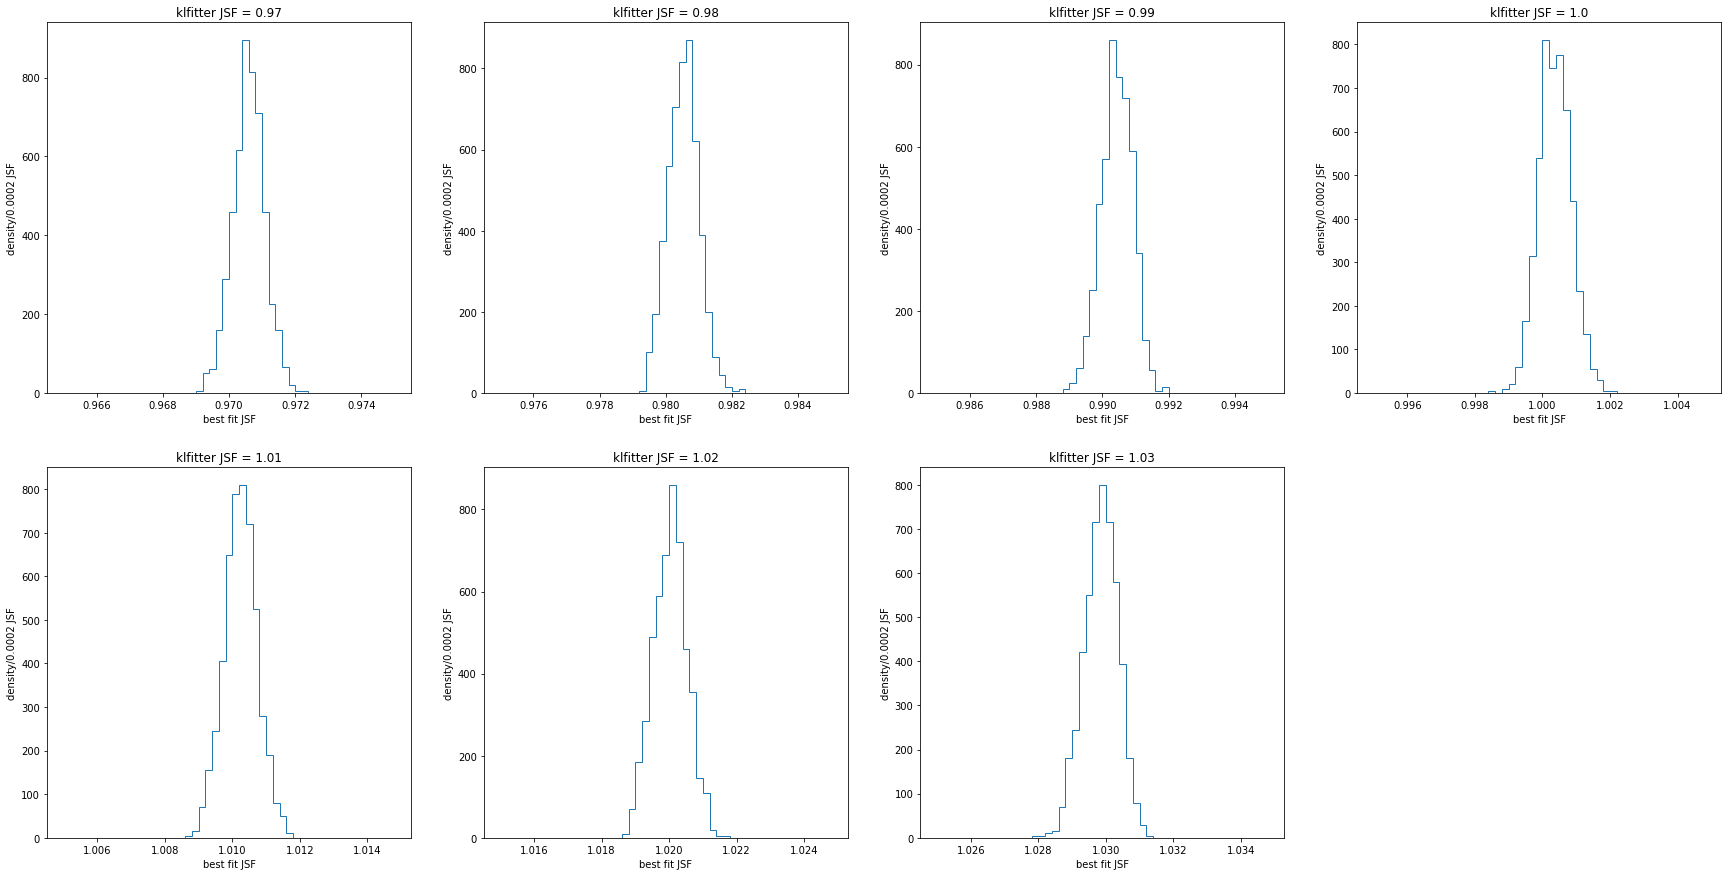

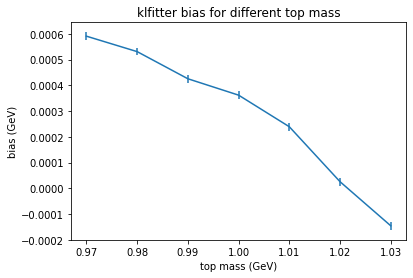

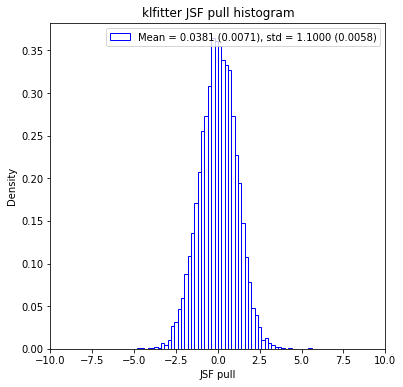

In [61]:
plt.figure(figsize=(30,15))
for i, m in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.005, m+0.005, 0.0002)
    plt.hist(sudo_klf_top_mean_dic[m], bins=bins_top, density=True, histtype='step')
    plt.title('klfitter JSF = {}'.format(m))
    plt.xlabel('best fit JSF')
    plt.ylabel('density/0.0002 JSF')
plt.show()

plt.errorbar(JSF_arr, [np.mean(sudo_klf_top_mean_dic[m])-m for m in JSF_arr], yerr=[np.std(sudo_klf_top_mean_dic[m])/np.sqrt(sudo_event) for m in JSF_arr])
plt.title('klfitter bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

plt.figure(figsize = (6, 6))

klf_top_bias = np.mean([np.mean(sudo_klf_top_mean_dic[m])-m for m in JSF_arr])
klf_top_pull = [(np.array(sudo_klf_top_mean_dic[m])-m-klf_top_bias)/sudo_klf_top_std_dic[m] for m in JSF_arr]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
klf_pull_mean, klf_pull_mean_std, klf_pull_sigma, klf_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('klfitter JSF pull histogram')
plt.xlim(-10, 10)
plt.xlabel('JSF pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [62]:
#Sudo experiment for spanet JSF
sudo_spanet_top_mean_dic = {}
sudo_spanet_top_std_dic = {}

for m in JSF_arr:
    sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_spanet, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in range(sudo_event):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_spanet_arr_func, m=m)
        minuit.limits=[(0.95, 1.05)]
        minuit.migrad()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_spanet_top_mean_dic[m] = mean
    sudo_spanet_top_std_dic[m] = std

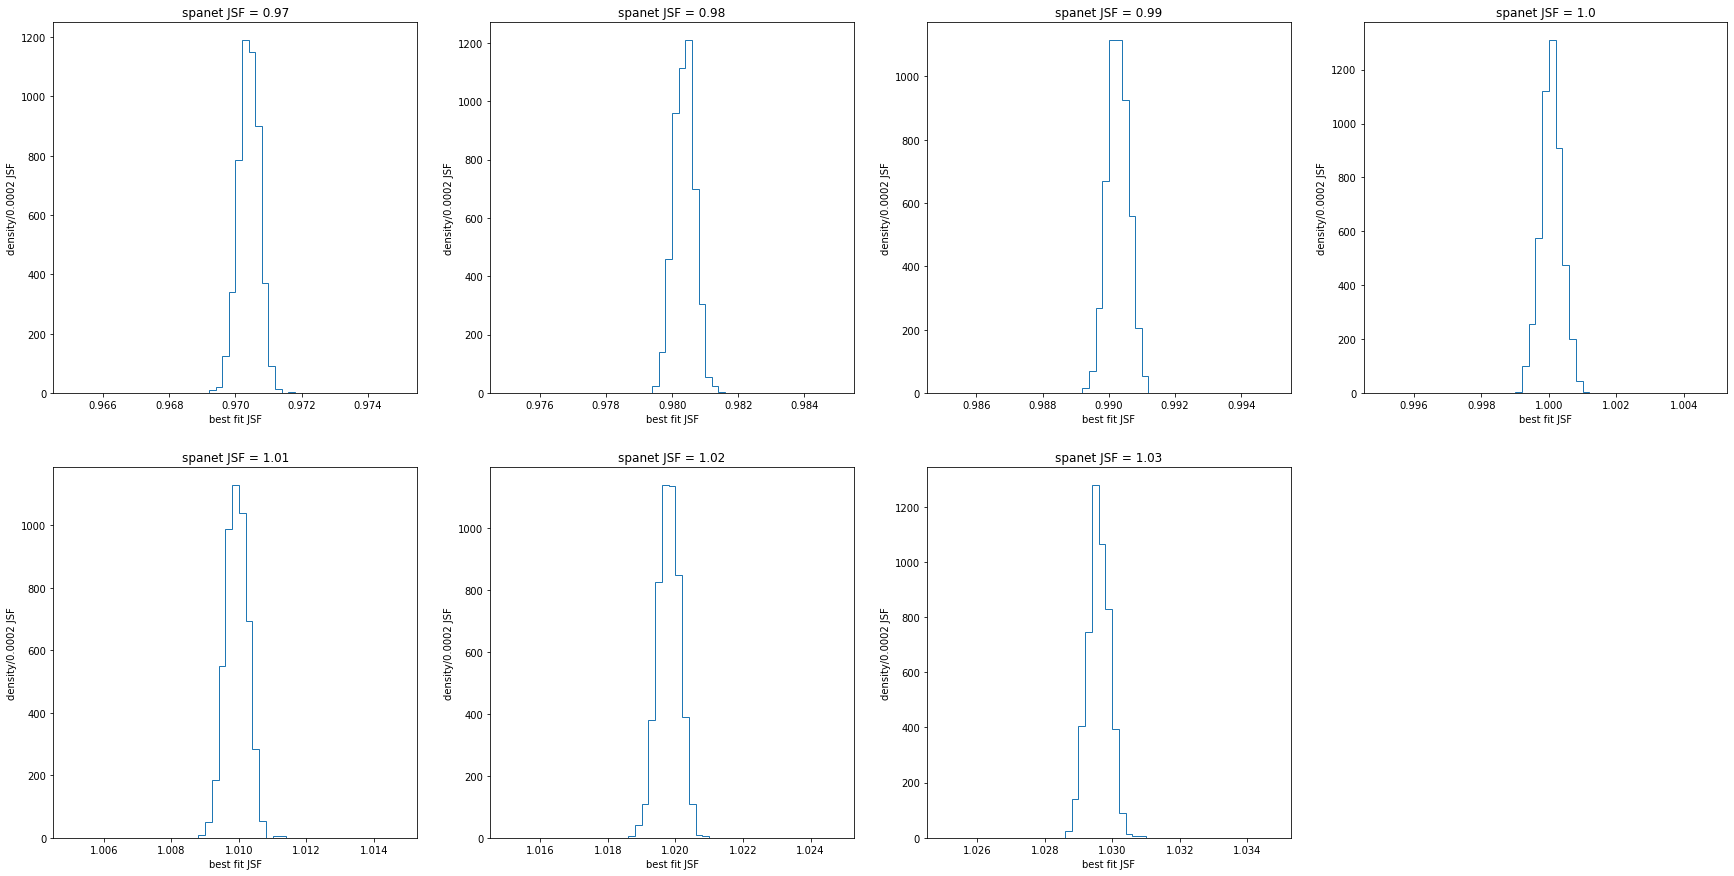

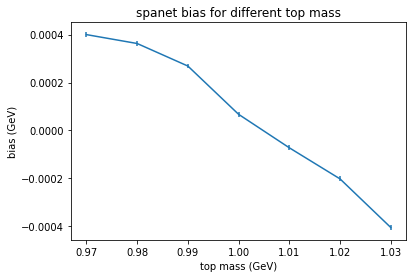

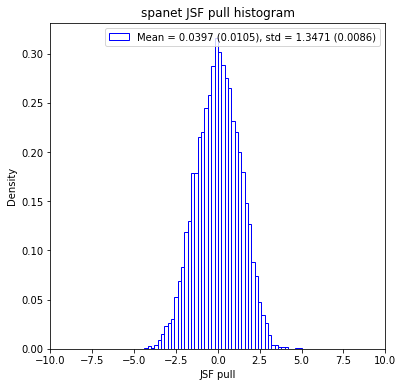

In [63]:
plt.figure(figsize=(30,15))
for i, m in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.005, m+0.005, 0.0002)
    plt.hist(sudo_spanet_top_mean_dic[m], bins=bins_top, density=True, histtype='step')
    plt.title('spanet JSF = {}'.format(m))
    plt.xlabel('best fit JSF')
    plt.ylabel('density/0.0002 JSF')
plt.show()

plt.errorbar(JSF_arr, [np.mean(sudo_spanet_top_mean_dic[m])-m for m in JSF_arr], yerr=[np.std(sudo_spanet_top_mean_dic[m])/np.sqrt(sudo_event) for m in JSF_arr])
plt.title('spanet bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

plt.figure(figsize = (6, 6))

spanet_top_bias = np.mean([np.mean(sudo_spanet_top_mean_dic[m])-m for m in JSF_arr])
spanet_top_pull = [(np.array(sudo_spanet_top_mean_dic[m])-m-spanet_top_bias)/sudo_spanet_top_std_dic[m] for m in JSF_arr]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
spanet_pull_mean, spanet_pull_mean_std, spanet_pull_sigma, spanet_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('spanet JSF pull histogram')
plt.xlim(-10, 10)
plt.xlabel('JSF pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()